## Building The Country Page Widgets

Charlie has added the following datasets to the **STAGING** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


```
[
    {
        "name": "IFL 2000",
        "gain": "27ed6d3c-89e8-4087-aa78-1b6619c0e8d5",
        "loss": "cbf299f8-f365-4ba3-ad10-b8c1324bea62",
        "extent": "1676bb7f-a858-4298-8faa-c85cb169ca20"
    },

    {
        "name": "IFL 2013",
        "gain": "19be9cf6-3dfc-4b77-b95e-39a6751e55bf",
        "loss": "2a4bf55c-7e0e-45cd-ac3f-f1e890c0bd22",
        "extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5"
    },

    {
        "name": "wdpa",
        "gain": "23519a73-f4b8-4bb6-8a6a-1d84c38debca",
        "loss": "9289fdf7-b2b0-4cbf-8951-9dd4dcd8ccd7",
        "extent": "8d7e23ec-bc8c-4434-bc6a-6ce40459b424"
    },

    {
        "name": "primary forests",
        "gain": "fd3b3a12-121e-4189-96a3-d8c26b70952d",
        "loss": "7a5b92ab-2d35-45f3-b923-20c9a46d4873",
        "extent": "b987b360-190e-4560-a632-03946347d226"
    },

    {
        "name": "biodiversity hot spots",
        "gain": "bd061864-8efb-41a7-8ba0-6f4d25ed1fd8",
        "loss": "32a963c1-26d7-4a21-b602-17144fd78c0f",
        "extent": "6c00c104-a75b-4b0b-9c33-0d0aa29cdf93"
    },

    {
        "name": "gadm28 only",
        "gain": "e78a9c36-ed15-467a-babd-0a5ac21d07d7",
        "loss": "88994c38-1ea1-4a32-82ca-073547d11176",
        "extent": "f0e01525-9576-4613-a74b-3290c94047ca"
    },

    {
        "name": "GFW Plantations",
        "gain": "94a883de-4eb4-4be8-a05f-c77ea8d9c6a3",
        "loss": "17a7970a-23ba-45ab-8004-37090b4e2502",
        "extent": "9b617bbb-b99b-4543-832d-665adeec3341"
    },

    {
        "name": "GFW Managed Forests",
        "gain": "c88957d7-4635-4fb7-b729-db565122529d",
        "loss": "c500cb21-fdf0-426b-9a89-4a581f33ed18",
        "extent": "f9e40f0f-4f9f-4d93-957d-1fa15dd29333"
    }
]
```

In [28]:
import requests
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Example of what is in the data tables and how to simply read them:
ds = "f0e01525-9576-4613-a74b-3290c94047ca" # gadm28 tree cover extent UMD 2013
url = "https://staging-api.globalforestwatch.org/query"
sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh=30 LIMIT 2")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://staging-api.globalforestwatch.org/query?sql=SELECT+%2A+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh%3D30+LIMIT+2
Status: 200


{'data': [{'_id': 'AV5SxVwVD0oexj_vqcdH',
   'adm1': 1,
   'adm2': 11,
   'area': 806167.3365414925,
   'iso': 'BRA',
   'thresh': 30},
  {'_id': 'AV5SxVwVD0oexj_vqcdP',
   'adm1': 1,
   'adm2': 3,
   'area': 1786.439707780866,
   'iso': 'BRA',
   'thresh': 30}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
     'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
   'http_method': 'POST',
   'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

# Tree cover widget

Default view where plantations data aviable for a country:

Uses:
    * Tree cover 2013 ("extent": "2cfc35b0-aa9b-4939-8265-ee643b3afeb5")
    * Plantations ("extent": "9b617bbb-b99b-4543-832d-665adeec3341")
    * Area of country

To calculate 3 slices in a pie chart:
    * Tree plantations
    * Natural forest (tree cover 2013 - tree plantations)
    * Non-forest (total area - tree cover 2013)



In [205]:
# note adm0 = BRA, adm1 = 4  is Amazonas
# adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
# adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
# adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
# adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)

url = "https://staging-api.globalforestwatch.org/query"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None

In [206]:
def extent_queries(ds, adm0, adm1=None, adm2 = None, threshold=30):
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND thresh = {threshold}")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area) as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND thresh = {threshold}")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area as value FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = {threshold}") 
    return sql

In [207]:
##  UMD Tree cover extent 2013 over gadm28 areas 
ds = "f0e01525-9576-4613-a74b-3290c94047ca"
sql = extent_queries(ds=ds, adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2013 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2013 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2013} ha")

Request for adm0 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 244872188.7236061}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}

BRA None None Gadm28 Tree cover extent = 244872188.7236061 ha


So far I don't like this value. It is way too low: the 2000 UMD extent data for Brazil gives 519,187,505 ha
From this table we are getting 244,872,188 ha. Doesn't look right...

In [208]:
# GFW plantations (should be area of forest intersecting tree plantations at admin2 level from gadm28 shapes)

ds = "9b617bbb-b99b-4543-832d-665adeec3341"
sql = extent_queries(ds=ds, adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    plantations = r.json().get('data')[0].get('value')
except:
    plantations = 0.0
print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")

Request for adm0 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+9b617bbb-b99b-4543-832d-665adeec3341+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 4659701.8839049935}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/9b617bbb-b99b-4543-832d-665adeec3341'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/9b617bbb-b99b-4543-832d-665adeec3341/clone'}}}

BRA None None plantation area = 4659701.8839049935 ha


In [209]:
def area_queries(adm0, adm1=None, adm2 = None):
    """If an admin0 or admin 1 area is requestd, use precalulated tables.
       If an admin2 is requested, calculate the area from the geometry.
    """
    if adm0 and not adm1 and not adm2:
        print('Request for adm0 area')
        sql = ("SELECT land as value "
                "FROM umd_nat_staging "
               f"WHERE iso = '{adm0}' "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and not adm2:
        print('Request for adm1 area')
        sql = ("SELECT land as value "
                "FROM umd_subnat_staging "
               f"WHERE iso = '{adm0}' "
               f" AND id1 = {adm1} "
                " AND year = 2001 "
                " and thresh = 30 ")
    elif adm0 and adm1 and adm2:
        print('Request for adm2 area')
        sql = ("SELECT ROUND(ST_AREA(the_geom::geography) * 0.0001) as value "
                "FROM gadm28_adm2 "
                f"WHERE iso = '{adm0}' "
                f"AND id_1 = {adm1} "
                f"AND id_2 = {adm2} ")
    return sql

In [210]:
# Total area (ha) of selected area based on gadm28 table in Carto account

sql = area_queries(adm0=adm0, adm1=adm1, adm2=adm2)

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

total_area = r.json().get('rows')[0].get('value')
print(f"\n {total_area} ha total area selected")

Request for adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+land+as+value+FROM+umd_nat_staging+WHERE+iso+%3D+%27BRA%27++AND+year+%3D+2001++and+thresh+%3D+30+ 

{'fields': {'value': {'type': 'number'}},
 'rows': [{'value': 853281125.672}],
 'time': 0.006,
 'total_rows': 1}

 853281125.672 ha total area selected


In [211]:
print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2013:g}, area={total_area:g}")
plantations, tree_cover_extent_2013 - plantations, total_area - tree_cover_extent_2013

plantations=4.6597e+06, tree cover=2.44872e+08, area=8.53281e+08


(4659701.8839049935, 240212486.83970112, 608408936.948394)

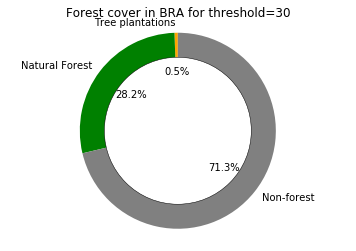

In [213]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Tree plantations', 'Natural Forest', 'Non-forest'
sizes = [plantations, tree_cover_extent_2013 - plantations, total_area - tree_cover_extent_2013]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['orange','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0} for threshold={threshold}')
plt.show()

#### Problems

** Areas **: As we calculate areas in this case dynamically from geometries, we will get inconsisntent results with the rest of the site. 
To resolve this, we need the areas pre-calculated in a table using the same method that they have previously been calculated from. I.e. it needs to match the same method of the `https://wri-01.carto.com/tables/umd_subnat_staging` table (which currently is at admin1 level.

* Possible Solution: Charlie could produce an areas table, that has the area of the gadm28 geometries.

** Tree Cover **: current extent area is incorrect. For Brazil, nationally, the values are off by around a factor of 2. Perhaps I have the wrong table, but I can't see another possible table that should be used in this case.

** Plantations **: Again, plantation areas look dubious.

## FAO FOREST Widget

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [ ]:
# Variables
adm0 = 'BRA'

In [169]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

fao_percent = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+fao.iso%2C+fao.name%2Cforest_planted%2C+forest_primary%2C+forest_regenerated%2C+fao.forest_primary%2C+fao.extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+is+not+null+AND+fao.iso+%3D+%27BRA%27+AND+a.year+%3D+2001+AND+a.thresh+%3D+30+ 

{'fields': {'area_ha': {'type': 'number'},
            'extent': {'type': 'number'},
            'forest_planted': {'type': 'number'},
            'forest_primary': {'type': 'number'},
            'forest_regenerated': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'}},
 'rows': [{'area_ha': 853281125.672,
           'extent': 492968489,
           'forest_planted': 2,
           'forest_primary': 41,
           'forest_regenerated': 57,
           'iso': 'BRA',
           'name': 'Brazil'}],
 'time': 0.007,
 'total_rows': 1}


In [171]:
# How to calculate the statitics needed based on the CARTO responses

naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

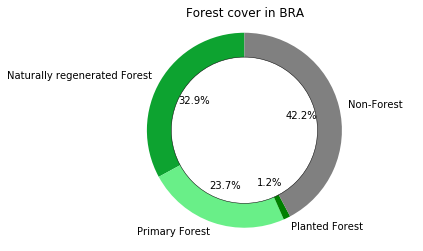

In [172]:
# FAO donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

In [177]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+fao.iso%2C+fao.name%2C+fao.forest_primary%2C+fao.extent+forest_extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+%3E+0+AND+a.year+%3D+2001+AND+a.thresh+%3D+30%29%2C+rank+AS+%28+SELECT+forest_extent+%2A+%28forest_primary%2F100%29%2Farea_ha+%2A+100+as+percent_primary+%2Ciso+from+mytable+ORDER+BY+percent_primary+DESC%29%2C+item+as+%28select+percent_primary+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+percent_primary+%3E+%28select+percent_primary+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 27}],
 'time': 0.038,
 'total_rows': 1}
27


In [189]:
# Dyanmic sentence for FAO plot

print(f"FAO data from 2015 shows that {adm0} is ")

if  non_forest/area_ha > 0.5:
    print('mostly non-forest. ')
else:
    print('mostly forest. ')

if primary_forest > 0:
    print(f'Primary forest occupies {primary_forest/area_ha*100:3.1f}% of the country.')
    print(f"This gives {adm0} a rank of {rank}th out of 110 countries in terms of its relative amount of primary forest.")

FAO data from 2015 shows that BRA is 
mostly forest. 
Primary forest occupies 23.7% of the country.
This gives BRA a rank of 27th out of 110 countries in terms of its relative amount of primary forest.


## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too

In [432]:
# Variables

# default (region-wide) comes from gadm28: loss table
loss_ds = "88994c38-1ea1-4a32-82ca-073547d11176"
loss_relative_extent_table = "f0e01525-9576-4613-a74b-3290c94047ca"

threshold=30
adm0 = 'BRA'
adm1 = None
adm2 = None
start=2001
end=2016

# adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres

In [433]:
def loss_queries(ds, adm0, start, end, adm1=None, adm2=None, threshold=30):
    if adm0 and not adm1 and not adm2:
        print(f'Request for adm0 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh={threshold} "
               "GROUP BY year ")
    elif adm0 and adm1 and not adm2:
        print('Request for  adm1 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    elif adm0 and adm1 and adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT year, sum(area) as area, sum(emissions) as emissions "
               f"FROM {ds} WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND year => {start} "
               f"AND year <= {end} "
               f"AND thresh= {threshold} "
               "GROUP BY year ")
    return sql

In [434]:
# Get the loss data grouped by year

url = "https://staging-api.globalforestwatch.org/query"

sql = loss_queries(ds=loss_ds, adm0=adm0, start=start, end=end, 
                   adm1=adm1, adm2=adm2, threshold=threshold)
    
print(sql)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

# Extract the year and loss
loss_json = r.json()
d = {}
for row in loss_json.get('data'):
    d[row.get('year')] = row.get('area')

Request for adm0 area
SELECT year, sum(area) as area, sum(emissions) as emissions FROM 88994c38-1ea1-4a32-82ca-073547d11176 WHERE iso = 'BRA' AND year => 2001 AND year <= 2016 AND thresh=30 GROUP BY year 
https://staging-api.globalforestwatch.org/query?sql=SELECT+year%2C+sum%28area%29+as+area%2C+sum%28emissions%29+as+emissions+FROM+88994c38-1ea1-4a32-82ca-073547d11176+WHERE+iso+%3D+%27BRA%27+AND+year+%3D%3E+2001+AND+year+%3C%3D+2016+AND+thresh%3D30+GROUP+BY+year+
Status: 200
{'data': [{'area': 3504343, 'emissions': 599104504, 'year': 2002},
          {'area': 3245861, 'emissions': 540572102, 'year': 2003},
          {'area': 3846083, 'emissions': 676406325, 'year': 2004},
          {'area': 3483878, 'emissions': 644550740, 'year': 2005},
          {'area': 2874114, 'emissions': 513805002, 'year': 2006},
          {'area': 2619106, 'emissions': 437501960, 'year': 2007},
          {'area': 2441599, 'emissions': 421134110, 'year': 2008},
          {'area': 1815228, 'emissions': 309399263,

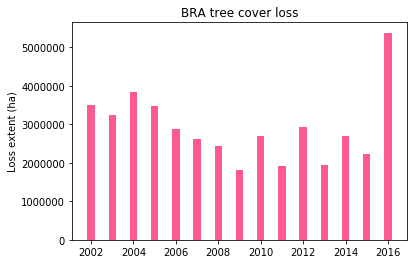

In [435]:
loss = d.values()
years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, loss, width, color='#FE5A8D')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(f'{adm0} tree cover loss')

plt.show()

Loss on hover should show % loss relative to Tree cover extent in the year 2000, over the appropriate
region. I.e. if someone is interested in the 'All region' default view, then the loss should come from the `gadm28 loss` table, and the extent (to calculate the relative loss) should come from the `gadm28 extent` table.

In [436]:
# Retrieve GADM28 extent for our area:

sql = extent_queries(ds=loss_relative_extent_table, adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)

print(sql)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

y2000_relative_extent = r.json().get('data')[0].get('value')

# The below value should be used to calculate a % loss on hover
print(y2000_relative_extent)

# e.g. on hover you should see:
for y,l in zip(years, loss):
    print(f"year {y}, {l} ha, {l/y2000_relative_extent * 100:3.2f}%")

Request for adm0 area
SELECT SUM(area) as value FROM f0e01525-9576-4613-a74b-3290c94047ca WHERE iso = 'BRA' AND thresh = 30
https://staging-api.globalforestwatch.org/query?sql=SELECT+SUM%28area%29+as+value+FROM+f0e01525-9576-4613-a74b-3290c94047ca+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30
Status: 200
{'data': [{'value': 244872188.7236061}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/f0e01525-9576-4613-a74b-3290c94047ca'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/f0e01525-9576-4613-a74b-3290c94047ca/clone'}}}
244872188.7236061
year 2002, 3504343 ha, 1.43%
year 2003, 3245861 ha, 1.33%
year 2004, 3846083 ha, 1.57%
year 2005, 3483878 ha, 1.42%
year 2006, 2874114 ha, 1.17%
year 2007, 2619106 ha, 1.07%
year 2008, 2441599 ha, 1.00%
year 2009, 1815228 ha, 0.74%
year 2010, 2686190 ha, 1.10%
year 2011, 1920608 ha, 0.78%
year 2012, 2915884 ha, 1.1

#### Dynamic sentence 

For the loss widget we also need a dynamic sentence. This will need to pull back 2016 area plantations loss too, and subtract this from the area loss, as WRI wants us to include this value.

We will need to be a bit intelligent though about using parts of this sentence - if it doesnt make sense to compare the subset of data selected by the user to plantations, then we should not do so.

In [437]:
# First find total emissions, and loss, and also the last year of emissions and loss

total_emissions = 0
total_loss = 0
last_year_loss = 0
last_year_emissions = 0
for row in loss_json.get('data'):
    total_emissions += row.get('emissions')
    total_loss += row.get('area')
    if row.get('year') == end:
        last_year_loss = row.get('area')
        last_year_emissions = row.get('emissions')
    
print([total_emissions, total_loss, last_year_loss, last_year_emissions])

[7407394191, 43582553, 5376186, 961582786]


In [438]:
# Next, pull back the Plantations loss data if it makes sense to do so

plantation_loss_table = "17a7970a-23ba-45ab-8004-37090b4e2502"

sql = loss_queries(ds=plantation_loss_table, adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold, start=start, end = end)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

plantation_loss_json = r.json().get('data')

# Grab the last years of data 
for row in plantation_loss_json:
    if row.get('year') == end:
        plantation_2016_loss = row.get('area')
        plantation_2016_emissions = row.get('emissions')
        
print([plantation_2016_loss, plantation_2016_emissions])

Request for adm0 area
https://staging-api.globalforestwatch.org/query?sql=SELECT+year%2C+sum%28area%29+as+area%2C+sum%28emissions%29+as+emissions+FROM+17a7970a-23ba-45ab-8004-37090b4e2502+WHERE+iso+%3D+%27BRA%27+AND+year+%3D%3E+2001+AND+year+%3C%3D+2016+AND+thresh%3D30+GROUP+BY+year+
Status: 200
{'data': [{'area': 198924.67411620915,
           'emissions': 31977693.50934291,
           'year': 2002},
          {'area': 168202.44601157308,
           'emissions': 25678431.97863412,
           'year': 2003},
          {'area': 206353.0915249586,
           'emissions': 31767266.980878115,
           'year': 2004},
          {'area': 213173.96968065947,
           'emissions': 32535265.89781475,
           'year': 2005},
          {'area': 209177.74415173382,
           'emissions': 30178801.924748182,
           'year': 2006},
          {'area': 196267.03709721565,
           'emissions': 28417400.716028214,
           'year': 2007},
          {'area': 189036.60156214982,
           'em

#### ISSUE

* How is there plantations loss over such a long period? (I Was expecting it starting in 2013 only...)

I need to check this with Charlie before I construct the plantations (inside/outside stacked bar version).

** build the dynamic sentence itself for the Tree cover loss widget **

In [439]:
# Dynamic sentence construction

if adm0 and not adm1 and not adm2:
    print(f"Between {start} and {end}, {adm0}")
if adm0 and adm1 and not adm2: 
    print(f"Between {start} and {end}, <name of admin1 region>")
if adm0 and adm1 and adm2:
    print(f"Between {start} and {end}, <name of admin2 region>")
    
print(f" lost {total_loss} ha of tree cover, equivalent to {total_emissions} tonnes of CO\u2082 of emissions.")

# IF IT MAKES SENSE TO DESCRIBE PLANTATION RELATIVE LOSS
# i.e. if not plantation data directly, or primary forests where there should be no plantations:

print(f"In {end}, there was {int(last_year_loss - plantation_2016_loss)} ha of loss excluding tree plantations, ")
print(f"equivalent to {int(last_year_emissions -  plantation_2016_emissions)} tonnes of CO\u2082 of emissions.")

Between 2001 and 2016, BRA
 lost 43582553 ha of tree cover, equivalent to 7407394191 tonnes of CO₂ of emissions.
In 2016, there was 5221724 ha of loss excluding tree plantations, 
equivalent to 944938093 tonnes of CO₂ of emissions.
